# Predicting Graduate School Admission Rates (Project Report)
DSCI 100 Group 21
- Benjamin Chang (14554159)
- Michael Sekatchev (58850397)
- Hatice Sila Yildiz (97630230)
- Weicong Zhang (11877164) 

## Introduction

Undergraduate students are often concerned with admission statistics and their chances of admission, so we decided to create a model that can predict one's chances of admissions based on the parameters that are usually considered as important for admission to graduate programs. As an increasing number of students choose to pursue their higher education in North American universities (Canada or the US), we chose to build our model based on international students admission. 

These parameters include *standardized test scores* such as English language proficiency tests TOFEL/IELTS (Test of English as a Foreign Language/International English Language Testing System) and aptitude tests such as GRE (Graduate Record Examinations), factors assessing *academic engagement* such as GPA and research experience, and *application-related* factors such as Statement of Purpose and Letter of Recommendation. These parameters are usually considered for the graduate program application regardless of the discipline.

Our project seeks to answer the question: Given scores on standardized tests, academic and non-academic components, what are the chances of admission to graduate school?

We found a dataset on Kaggle created by Mohan S. Acharya, and it is accessible to the public as a csv file. It contains 400 observations (rows) and 9 columns: Serial Number, GRE Score, TOEFL Score, University Rating, Statement of Purpose, Letter of Recommendation, Undergraduate GPA, Research Experience, and Chance of Admission. For the purpose of this project, we try to create the model based on the selected factors below:

- Standardized test scores
  - `GRE.score`
  - `TOEFL.score`
- Academic Engagement
  - `CGPA`
  - `Research` (0 = None, 1 = Has Experience)
- Application Related
  - Statement of Purpose (`SOP`: Measured from 1-5, 5 being strongest)
  - Letter of Recommendation (`LOR`: Measured from 1-5, 5 being strongest)


## Method

In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally) # For ggpairs()

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.3 
✔ parsnip   0.1.3    

### Loading Data

After loading the data from the URL, we tidied the data a bit by editing the column names for easier access and transforming the categorical variables into factors. 

In [ ]:
# The database was taken from keggle and uploaded to a github page from which it can be loaded:
data <- read_csv("https://raw.githubusercontent.com/msekatchev/DSCI100Project/main/Admission_Predict.csv")
names(data)<-str_replace_all(names(data), c(" " = "." , "," = "" ))
data <- mutate(data, University.Rating = as_factor(University.Rating))
data <- mutate(data, Research = as_factor(Research))
head(data)

Parsed with column specification:
cols(
  `Serial No.` = col_double(),
  `GRE Score` = col_double(),
  `TOEFL Score` = col_double(),
  `University Rating` = col_double(),
  SOP = col_double(),
  LOR = col_double(),
  CGPA = col_double(),
  Research = col_double(),
  `Chance of Admit` = col_double()
)



Serial.No.,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65
6,330,115,5,4.5,3.0,9.34,1,0.90


### Creating Data Split and Exploring the Dataset

In [ ]:
# Data split - 75% used for training the model, 25% used for testing
admissions_split <- initial_split(data, prop = 0.75, strata = Chance.of.Admit)
admissions_training <- training(admissions_split)
admissions_testing <- testing(admissions_split)

Since the columns `University.Rating` and `Research` are categorical variables, the summary function gives a count of each possible value.

In [ ]:
summary(admissions_training)

   Serial.No.    GRE.Score      TOEFL.Score    University.Rating
 Min.   :  1   Min.   :290.0   Min.   : 93.0   1:19             
 1st Qu.:100   1st Qu.:308.0   1st Qu.:103.0   2:80             
 Median :200   Median :317.0   Median :107.0   3:99             
 Mean   :200   Mean   :316.6   Mean   :107.5   4:56             
 3rd Qu.:299   3rd Qu.:325.0   3rd Qu.:112.0   5:47             
 Max.   :399   Max.   :340.0   Max.   :120.0                    
      SOP             LOR             CGPA       Research Chance.of.Admit 
 Min.   :1.000   Min.   :1.000   Min.   :6.800   0:142    Min.   :0.3400  
 1st Qu.:3.000   1st Qu.:3.000   1st Qu.:8.170   1:159    1st Qu.:0.6400  
 Median :3.500   Median :3.500   Median :8.650            Median :0.7300  
 Mean   :3.424   Mean   :3.449   Mean   :8.609            Mean   :0.7244  
 3rd Qu.:4.000   3rd Qu.:4.000   3rd Qu.:9.080            3rd Qu.:0.8200  
 Max.   :5.000   Max.   :5.000   Max.   :9.920            Max.   :0.9700  

The relationship between each variable can also be examined visually using `ggpairs()`:

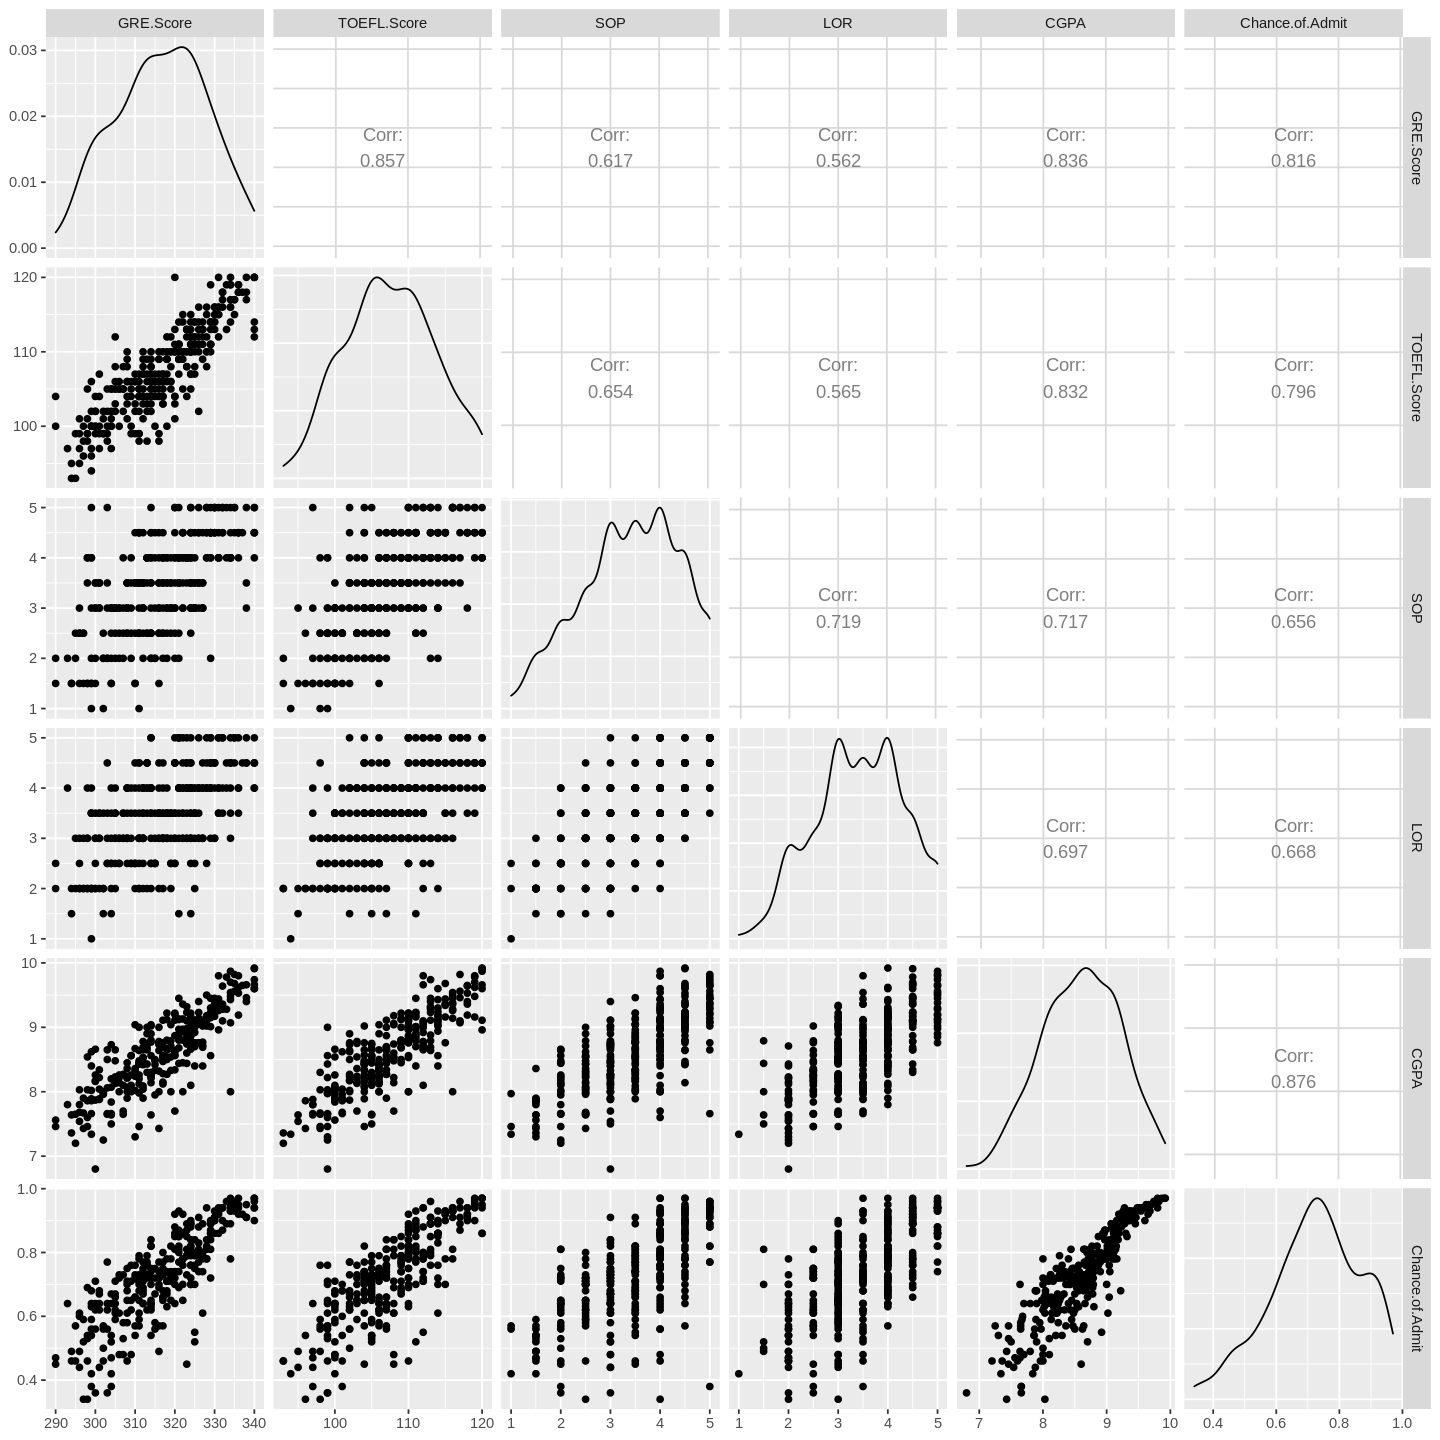

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12)
# selecting to compare only the variables used for the analysis
select(admissions_training,GRE.Score, TOEFL.Score, SOP, LOR, CGPA,Chance.of.Admit) %>% ggpairs()

*Fig 1 - plot showing relationships between each variable used in the regression analysis.*

The last row of the ggpairs plot shows the relationship of each variable with the admission chance, the variable we want to predict. We can see strong positive correlations with each variable. The `CGPA` variable seems to show the strongest positive relationship, which is why we recreated the `CGPA` vs `Chance.of.Admit` plot below for a clearer visualization:


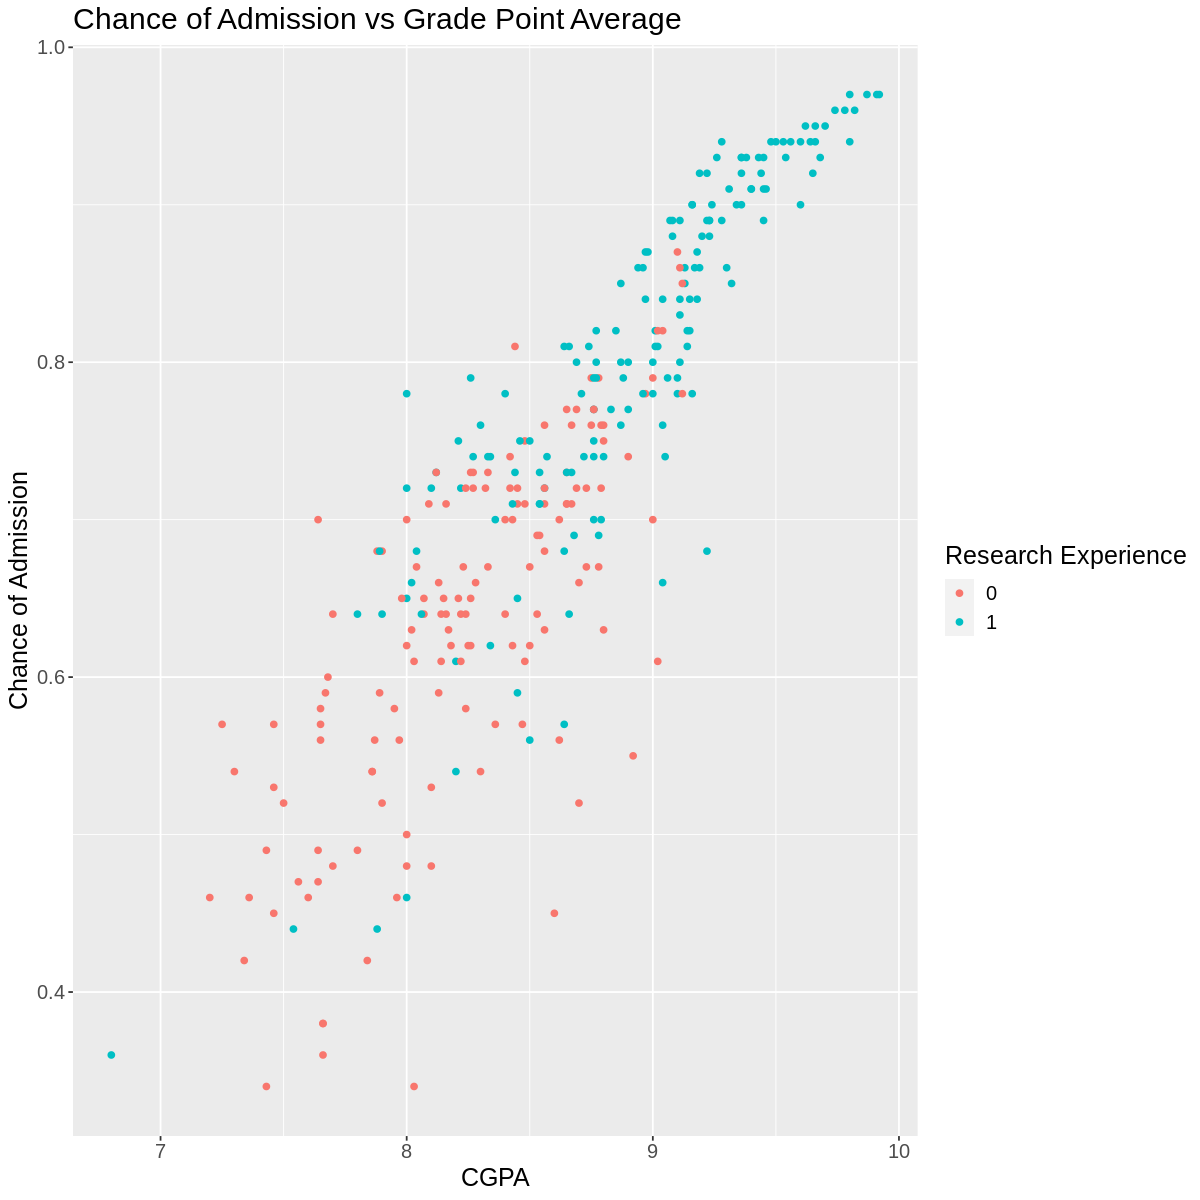

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot <- ggplot(admissions_training, aes(x=CGPA, y=Chance.of.Admit, color = Research)) +
    geom_point() +
    labs(title = "Chance of Admission vs Grade Point Average", 
         x = "CGPA", 
         y = "Chance of Admission", 
         color = "Research Experience") +
    theme(text = element_text(size=15))

plot

*Fig 2 - plotting students' grade point average against against admission chance, with a color distinction for whether or not they have research experience.*

We can see there is a strong positive linear relationship between GPA and the admissions chance, and that students with research experience tend to have higher chances of being admitted. Note that since research experience is a categorical variable, it was not used in our analysis, but we thought it was interesting to see its effect of graduate admission chance. It's clear that students with research experience are more likely to be admitted.

## KNN Regression
### Setting Up Tuning Model

Here is where we set up the recipe and model specification for determining the best value for neighbors. Note we have left out any categorical variables and have designed our model to be purely based on numerical predictors. In this step, we are also setting up a 5-fold cross validation in order to tune for the hyperparemeter neighbors. 

In [ ]:
# Creating knn recipe for scaling and centering the quantitative variables
# Predictors have different scales, so they need to be scaled prior to analysis
knn_recipe <- recipe(Chance.of.Admit ~ GRE.Score + TOEFL.Score + SOP + LOR + CGPA, data = admissions_training) %>%
                  step_scale(all_predictors()) %>%
                  step_center(all_predictors())

# knn regression model
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                  set_engine("kknn") %>%
                  set_mode("regression")

# Splitting into 5 data sets for cross-validation
vfold <- vfold_cv(admissions_training, v = 5, strata = Chance.of.Admit)

# combining the recipe and model into a knn workflow
knn_workflow <- workflow() %>%
                 add_recipe(knn_recipe) %>%
                 add_model(tuning_spec)

knn_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Hyperparameter Tuning for neighbors

We are tuning for the hyperparemeter neighbors in range 1 - 200 and taking the one that produces the lowest rmse error (assigned to knn_min)

In [ ]:
# 200 values of k neighbors are tested:
gridvals <- tibble(neighbors = seq(1,200))

# Applying the workflow with k from 1 to 200, and collecting the resulting RMSE and RSQ
knn_results <- knn_workflow %>%
                   tune_grid(resamples = vfold, grid = gridvals) %>%
                   collect_metrics()

head(knn_results)

# extracting the k value that has the lowest RMSE
knn_min <- knn_results %>%
               filter(.metric == 'rmse') %>%
               filter(mean == min(mean)) %>%
               select(neighbors) %>%
               pull()

knn_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.08652413,5,0.007184829,Model001
1,rsq,standard,0.65970287,5,0.045664215,Model001
2,rmse,standard,0.07745113,5,0.004419214,Model002
2,rsq,standard,0.70880947,5,0.028489780,Model002
3,rmse,standard,0.07594563,5,0.002062595,Model003
3,rsq,standard,0.71885228,5,0.018601876,Model003


[1] 16

### Building Actual KNN Regression Model and Predicting Testing Dataset

Having found the optimal value of neighbors above, we can now construct an actual prediction model on which we can train and use to make predictions. 

In [ ]:
# Creating an optimized KNN regression specification using the best K neighbors determined above
optimized_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = knn_min) %>%
            set_engine("kknn") %>%
            set_mode("regression")

# Reusing the same recipe when creating the workflow, and fitting to the training data.
knn_fit <- workflow() %>%
           add_recipe(knn_recipe) %>%
           add_model(optimized_knn_spec) %>%
           fit(data = admissions_training)

# Predicting on the testing data
knn_predictions <- knn_fit %>% predict(admissions_testing) %>% bind_cols(admissions_testing)

# Obtaining the metrics from the predictions on the testing set
knn_summary <- knn_predictions %>% metrics(truth = Chance.of.Admit, estimate = .pred) 


head(knn_predictions)
head(knn_summary)

.pred,Serial.No.,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.713750,4,322,110,3,3.5,2.5,8.67,1,0.80
0.711250,7,321,109,3,3.0,4.0,8.20,1,0.75
0.748125,11,325,106,3,3.5,4.0,8.40,1,0.52
0.841250,12,327,111,4,4.0,4.5,9.00,1,0.84
0.637500,14,307,109,3,4.0,3.0,8.00,1,0.62
0.501250,28,298,98,2,1.5,2.5,7.50,1,0.44


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.07490796
rsq,standard,0.71931020
mae,standard,0.05369318


### Adding new `total.score` variable to visualize data

In order to get a good visualization of the data, we decided to sum up our predictors into a single value which we call `total.score`. This is to better visualize and test our hypothesis that higher scores in all metrics will lead to a higher chance of graduate school admission. 

.pred,Serial.No.,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit,total.score
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.713750,4,322,110,3,3.5,2.5,8.67,1,0.80,446.67
0.711250,7,321,109,3,3.0,4.0,8.20,1,0.75,445.20
0.748125,11,325,106,3,3.5,4.0,8.40,1,0.52,446.90
0.841250,12,327,111,4,4.0,4.5,9.00,1,0.84,455.50
0.637500,14,307,109,3,4.0,3.0,8.00,1,0.62,431.00
0.501250,28,298,98,2,1.5,2.5,7.50,1,0.44,407.50


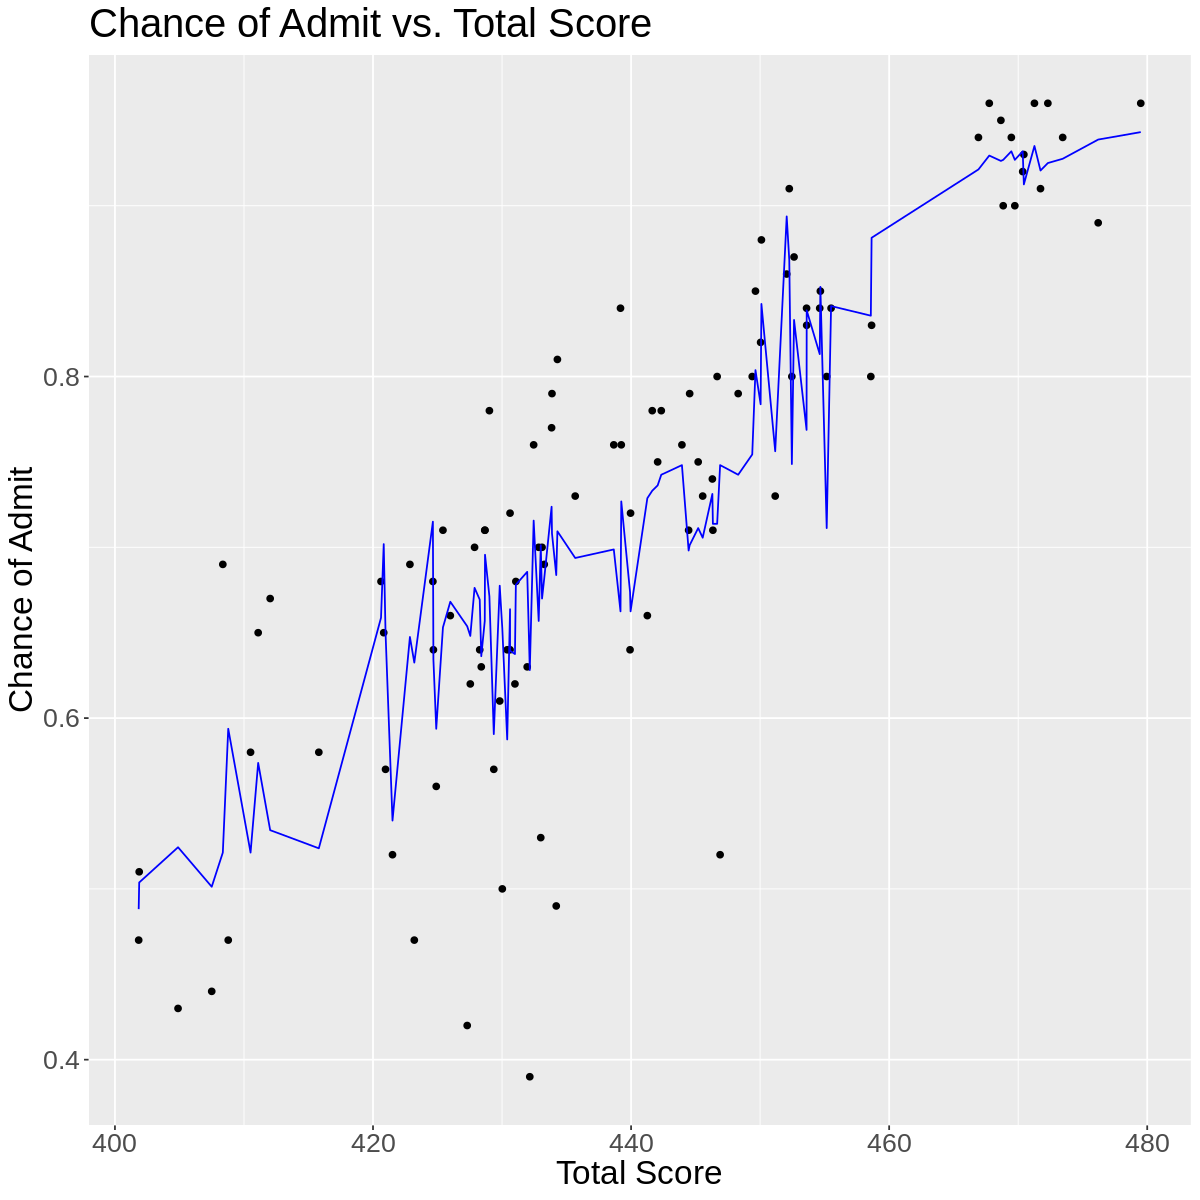

In [ ]:
# adding the total.score column to the dataset with predictions on testing data
knn_predictions_total_score <- knn_predictions %>%
        mutate(total.score = GRE.Score + TOEFL.Score + SOP + LOR + CGPA)

head(knn_predictions_total_score )


knn_plot <- ggplot(knn_predictions_total_score , aes(x = total.score, y = Chance.of.Admit)) +
  geom_point() + geom_line(aes(x = total.score, y = .pred), color = "blue") + 
  labs(x = "Total Score", 
       y = "Chance of Admit", 
       title = "Chance of Admit vs. Total Score") +
  theme(text = element_text(size=20))

knn_plot

*Fig 3 - plotting the chance of admissions against the new `total.score` variable. The testing dataset values are shown as black points, and the KNN regression model's prediction is shown in blue*

We can see that the chance of admissions is in a strong linear relationship with the calculated `total.score`variable. We can also see our KNN prediction closely following the data, though it visually appears to be overfitting the data.

## Linear Regression Model

Here we decide to also build and fit a linear regression model in order to compare with our knn-regression one above. We believe the one that produces the smallest RMSE error will be the better model to move forward with. 

In [ ]:
# Creating a specification for linear regression
lm_spec <- linear_reg() %>%
            set_engine("lm") %>%
            set_mode("regression")

# Creating a recipe, once again using the chosen variables for regression analysis
lm_recipe <- recipe(Chance.of.Admit ~ GRE.Score + TOEFL.Score + SOP + LOR + CGPA, data = admissions_training) 

# Combining the model, recipe and training data in a workflow
lm_fit <- workflow() %>%
            add_recipe(lm_recipe) %>%
            add_model(lm_spec) %>%
            fit(data = admissions_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    GRE.Score  TOEFL.Score          SOP          LOR         CGPA  
  -1.566877     0.002859     0.002550    -0.003328     0.021491     0.121875  


As observed through initial visualization with `ggpairs()`, the CGPA predictor has the strongest influence in predicting the chances of graduate admission. 

In [ ]:
# Predicting on the testing data
lm_predictions <- lm_fit %>%
                predict(admissions_testing) %>%
                bind_cols(admissions_testing)

# Calculating the metrics from the prediction (we are interested in the RMPSE)
lm_summary <- lm_predictions %>% metrics(truth = Chance.of.Admit, estimate = .pred)

head(lm_predictions)

head(lm_summary)

.pred,Serial.No.,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.7327957,4,322,110,3,3.5,2.5,8.67,1,0.80
0.7040068,7,321,109,3,3.0,4.0,8.20,1,0.75
0.7305021,11,325,106,3,3.5,4.0,8.40,1,0.52
0.8311756,12,327,111,4,4.0,4.5,9.00,1,0.84
0.6147935,14,307,109,3,4.0,3.0,8.00,1,0.62
0.4976538,28,298,98,2,1.5,2.5,7.50,1,0.44


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.06545296
rsq,standard,0.78696125
mae,standard,0.04561299


Once again, we calcualted the `total.score` for a way to visualize our data and compare with the KNN regression model.

.pred,Serial.No.,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit,total.score
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.7327957,4,322,110,3,3.5,2.5,8.67,1,0.80,446.67
0.7040068,7,321,109,3,3.0,4.0,8.20,1,0.75,445.20
0.7305021,11,325,106,3,3.5,4.0,8.40,1,0.52,446.90
0.8311756,12,327,111,4,4.0,4.5,9.00,1,0.84,455.50
0.6147935,14,307,109,3,4.0,3.0,8.00,1,0.62,431.00
0.4976538,28,298,98,2,1.5,2.5,7.50,1,0.44,407.50


`geom_smooth()` using formula 'y ~ x'



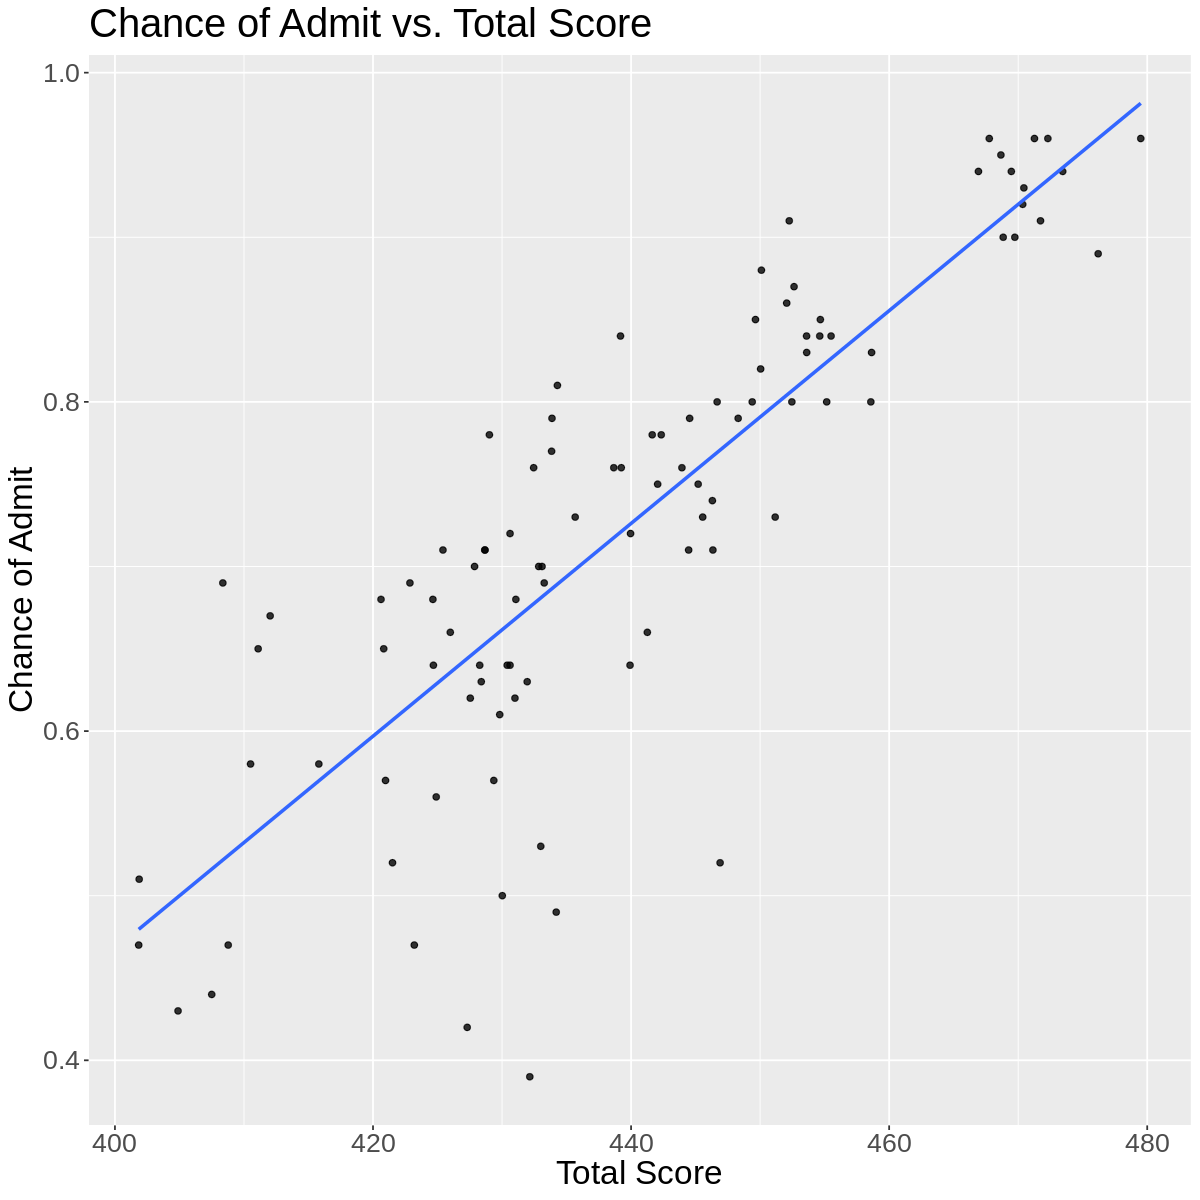

In [ ]:
# Calculating the total score for visualization
lm_predictions_total_score <- lm_predictions %>%
        mutate(total.score = GRE.Score + TOEFL.Score + SOP + LOR + CGPA)

head(lm_predictions_total_score)

lr_plot <- ggplot(lm_predictions_total_score, aes(x = total.score, y = Chance.of.Admit)) +
    geom_point(alpha = 0.8) +
    labs(x = "Total Score", 
       y = "Chance of Admit", 
       title = "Chance of Admit vs. Total Score") +
    scale_y_continuous()  +
    geom_smooth(method = "lm", se = FALSE)  +
    theme(text = element_text(size=20))
lr_plot

*Fig 3 - plotting the chance of admissions against the new `total.score` variable. The testing dataset values are shown as black points, and the linear regression model's prediction is shown in blue*

We can see that a linear fit is also a good choice for the data. Comparing with the KNN regression plot, we might even expect this linear fit to perform better, with a lower RMSPE, but it is hard to visually tell if this fit underfits the data more than the KNN fit overfits the data. We will compare the RMSPE values below.

## Results and Discission

Below are our results for each regression analysis:

#### KNN Regression:

In [ ]:
head(knn_summary)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.07490796
rsq,standard,0.71931020
mae,standard,0.05369318


#### Linear Regression

In [ ]:
head(lm_summary)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.06545296
rsq,standard,0.78696125
mae,standard,0.04561299


## Discussion and Conclusion

After carrying out both a KNN and linear regression analysis and comparing the RMSPE for both methods, it was found that the linear regression method was a better fit for the data; The RMSPE value produced by the linear regression analysis was consistently ~5% lower than the RMSPE from the KNN model. After initial data exploration, it was clear that all variables were in strong positive relationships with `Admissions.Chance` which appeared linear in individual visualizations with the predictor. This result is therefore not unexpected.

The findings of this model can aid students applying for graduate degrees in increasing their chances of admission. Students can get a better idea of whether they should prioritize their standardized tests or other components of their application as well as how much time they should allocate to studying for these exams. Universities can also use this model of prediction to support their decision making process.

We also compared our results with two other published papers which analysed the same dataset:

The research done by Alghamdi, Amal, et al uses a machine learning approach for their data analysis on the same dataset as we did. This project compares and evaluates three learning strategies: linear regression, decision tree, and logistic regression model. The logistic regression model was found to be the best one as measured by minimal error. Comparing our regression model with theirs, while the RMSPE of our linear regression model is about `0.065` (result varies slightly with each iteration), theirs is `0.076`. Our model's RMSPE was consistently lower than theirs. Despite the smaller RMSPE from the linear regression model, we still found it to be better than the K-nearest neighbors regression model. Comparing the coefficients from our linear fit with those in this paper, we notice the following differences:
- The Statement of Purpose (SOP) was the strongest predictor in their analysis (ours was CGPA)
- They used all predictors in their analysis (including the categorical ones - Research experience and university rating), and in contrast they didn't add a new variable called Total Score to represent aggregated numerical parameters, which we thought is more communicative for the purpose of our project.
<br><br>

Another relevant research we found in the literature is the project carried out by Apoorva D A, Chithra, et al. We found that they used different approaches to visualisation. Their visualisation focuses on bi-variate relationship by visualising the relationship between Chance of Admission of individual predicting factors such as TOFEL score, GRE and CGPA. They also used a three-dimensional model to visualise the relationship between the three predictors mentioned above. In comparison, we calculated a total score to visualise a bi-variate relationship between the total score and the chance of admission, and used ggpairs to visualise the effect of each predicting factors and their relationship with each other. 

To sum up, we found our model and our visualisation to be clearer, more comprehensive and more illustrative compared with theirs. 

Our model visualizes the total score of all the standardized tests. Future research can focus on studying the correlations between the individual tests and chances of admissions to examine and predict which tests are more useful when applying for graduate school. Our model was limited to the use of numerical variables, hence, future analysis could be done using other variables, such as categorical ones. Other models besides k-nn and linear regression, such as the machine learning approach used by Alghamdi, Amal, et al and the models used by Apoorva D A, Chithra, et al,  can be compared to possibly find a more accurate method of prediction. The differences in results between different countries can also be considered, as the standardized tests would differ and/or have varying effectiveness worldwide. The chances of admission for different universities could also be examined so that students can make realistic choices on what universities might accept them based on their test scores.

## References

Alghamdi, Amal, et al. “A Machine Learning Approach for Graduate Admission Prediction.” *Proceedings of the 2020 2nd International Conference on Image, Video and Signal Processing*, 2020, https://doi.org/10.1145/3388818.3393716, https://github.com/msekatchev/DSCI100Project/blob/main/a%20machine%20learning%20approach%20for%20graduate%20admission%20prediction.pdf

Apoorva D A, Chithra, et al. “Prediction for University Admission Using Machine Learning.” *International Journal of Recent Technology and Engineering Regular Issue*, vol. 8, no. 6, 2020, pp. 4922–4926., https://www.ijrte.org/wp-content/uploads/papers/v8i6/F9043038620.pdf.

Mohan S Acharya, Asfia Armaan, Aneeta S Antony. “A Comparison of Regression Models for Prediction of Graduate Admissions.” *IEEE International Conference on Computational Intelligence in Data Science 2019*, https://www.kaggle.com/mohansacharya/graduate-admissions